## Autoencoder in Tensorflow
Implementation of a symetrical deep autoencoder with weight-tying using keras

In [0]:
import numpy as np
import tensorflow as tf
import tarfile
import io
import os
import psutil
import time
from tensorflow import keras
from google.cloud import storage
from tensorflow.keras.models import Model 
from keras import backend as K
from PIL import Image
from matplotlib import pylab as plt

Using TensorFlow backend.


## Data Prepeocessing

#### Connect with GCS bucket

In [0]:
bucket_name = "dataproc-staging-us-central1-759291875656-wohgf1sk"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
file_prefix = "data/"
blobs = bucket.list_blobs(prefix=file_prefix, delimiter = '/')

In [0]:
# list files in folder
for blob in blobs:
    print(blob.name)

#### Download file from blob

In [0]:
# run this and skip the following cell if the following had been run
file_name = "val_data.tar"

In [0]:
# RUN ONCE ONLY! 
# only run the above cell if this cell had been ran.
import time
start_time = time.time()

file_name = file_name
blob = bucket.get_blob(file_prefix + file_name)
blob.download_to_filename(file_name)

end_time = time.time()
print(f'Total preprocessing time: {round((end_time-start_time)/60, 2)} minutes')

#### Functions for Loading and Preprocessing

In [0]:
def batch_preprocess_imgs(archive, preprocess_func, 
                          preprocess_args, start, end):
    """
    batch preprocess images from an archive by reading and 
    preprocessing files within the start and end of the batch
    Args:
        archive: (Tarfile) an archive of image files
        preprocess_func: (func) functions for preprocessing
        start: (int) starting index
        end: (int) ending index (non-inclusive)
    Returns:
        result: (ndarray) an array of the preprocesed batch
    """
    result = []
    idx = start
    
    while idx < end:
        member = archive.next()
        f = tar_file.extractfile(member)
        if f is not None:
            content = f.read()
            result.append(preprocess_func(content, preprocess_args))
            idx += 1
    return result

In [0]:
def img_to_ndarray(img_data, img_dim):
    """ 
    Resize image so that it has height dim_h and flatten the image
    Args:
        img_data: (bytes) image data
        img_dim: typle(width, height)
    Returns:
        img: (np array) the resized and flattened image
    """
    img = Image.open(io.BytesIO(img_data))
    img = img.resize(img_dim).convert(mode = 'L') # convert to grey scale
    return np.array(img) / 255.0

#### Calculate Data Size

In [0]:
# run this if the following had been run
# uncomment either eitheir val or train data

data_size = 36500  # val_data 36500 files
# data_size = 1803460  # train_data 1.8 million files 

In [0]:
# # RUN ONCE ONLY! 
# # only run the above cell if this cell had been ran.

# # get the size of data (num of images)
# with tarfile.open(file_name) as tar_file:
#     member = tar_file.next()
#     data_size = 0
#     interval = 100000  # every 100K file
#     while member != None:
#         if member.isfile():
#             data_size += 1
#         if data_size % interval == 0:
#             print(f'counting: {data_size/100000} hundred thousand files')
#         member = tar_file.next()

#### Batch Loading and Preprocessing

In [0]:
import time
start_time = time.time()

# setup
img_size = (32, 32)
tar_file = tarfile.open(file_name)
BATCH_SIZE = 1000

# save out batches to fp
saved_filename = 'val_img_array.pkl'
fp = np.memmap(saved_filename, dtype='float32', mode='w+',
               shape=(data_size, img_size[0], img_size[1]))

# batch loading and preprocessing
for i in range(data_size // BATCH_SIZE + 1):
    start, end = i*BATCH_SIZE, min((i+1)*BATCH_SIZE, data_size)
    result = batch_preprocess_imgs(archive=tar_file,
                                   preprocess_func=img_to_ndarray,
                                   preprocess_args=img_size,
                                   start=start, end=end)
    fp[start:end] = np.array(result)
    time_elapsed = round(time.time()-start_time, 2)
    print(f'loading batch ({i+1} of {data_size // BATCH_SIZE + 1})')
    print(f'time elapsed: {time_elapsed//60} minutes {round(time_elapsed%60, 2)} seconds')
    
tar_file.close()
end_time = time.time()
print(f'Total preprocessing time: {round((end_time-start_time)/60, 2)} minutes')

## Load Preprocessed Data

In [0]:
preprocessed_filename = 'train_img_array.pkl'
data_size = 1803460
img_size = (32, 32)
fp = np.memmap(preprocessed_filename, dtype='float32', mode='r+',
               shape=(data_size, img_size[0], img_size[1]))

(1803460, 32, 32)


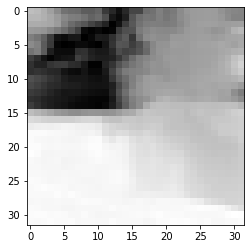

In [0]:
img_array = fp
print(img_array.shape)
plt.imshow(img_array[4], cmap='Greys')

In [0]:
# call once only
# shuffling training data
# np.random.shuffle(fp[:1803000])

(1803000, 32, 32)


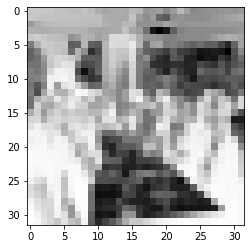

In [0]:
train_data = fp[:1803000]
print(train_data.shape)
plt.imshow(train_data[100], cmap='Greys')

In [0]:
train_data_10k = train_data[:10000]
train_data_50k = train_data[:50000]
train_data_100k = train_data[:100000]
train_data_200k = train_data[:200000]
train_data_500k = train_data[:500000]

## AutoencoderBuilder
The builder class abstracts away the process of building a multi-layered, symmetrical tied-weight autoencoder

In [0]:
class AutoencoderBuilder():
  """
  Builder for a multi-layer, symetrical autoencoder with weight-tying
  """
  def __init__(self, input_shape, encoder_layer_sizes, activation='relu'):
    """
    The decoder layer sizes will be symetrical of the encoder. The last layer
    of the encoding layer describes the bottle-neck layer or the latent 
    representation of the input. Note: the input data must be normalized. 
    The input shape should be (rows, cols, channels)
    """
    self.input_shape = input_shape
    self.encoder_layer_sizes = encoder_layer_sizes
    self.activation = activation
    
  def build(self):
    """Builds the autoencoder"""
    encoder_layers = self._encoder()
    decoder_layers = self._decoder(encoder_layers)
    return keras.models.Sequential(encoder_layers + decoder_layers)

  def _encoder(self):
    """Builds the encoding layers"""
    layers = []
    layers.append(keras.layers.Flatten(input_shape=(self.input_shape)))
    for size in self.encoder_layer_sizes:
      layers.append(keras.layers.Dense(size, activation=self.activation, 
                                       name=f'layer_size_{size}'))
    return layers

  def _decoder(self, encoder_layers):
    """
    Builds the decoding layers by transposing encoder layers such
    that the encoder and decoder share weights
    """
    layers = []
    for el in encoder_layers[:1:-1]:
      layers.append(DenseTranspose(el, activation=self.activation))
    layers.append(DenseTranspose(encoder_layers[1], activation='sigmoid'))
    layers.append(keras.layers.Reshape(self.input_shape))
    return layers

### Custom weight-tying layers

In [0]:
# weight-tying dense (transpose) layer
# cite: https://mc.ai/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it/

class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.dense = dense
    self.activation = keras.activations.get(activation)
  
  def build(self, input_shape):
    super().build(input_shape)
    self.bias = self.add_weight(name="bias",
                                shape=(self.dense.input_shape[-1]),
                                initializer="zeros")
  
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.bias)

### Memory Usage Monitoring

In [0]:
pid = os.getpid()
ps = psutil.Process(pid)

### Simple Autoencoder Training Loop

In [0]:
# measure memory usage before training
before_memory = ps.memory_info()

In [0]:
ae_builder = AutoencoderBuilder(input_shape=(32, 32),
                                encoder_layer_sizes=[512, 256, 128],
                                activation='selu')
ae = ae_builder.build()
ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
layer_size_512 (Dense)       (None, 512)               524800    
_________________________________________________________________
layer_size_256 (Dense)       (None, 256)               131328    
_________________________________________________________________
layer_size_128 (Dense)       (None, 128)               32896     
_________________________________________________________________
dense_transpose (DenseTransp (None, 256)               33152     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 512)               131840    
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 1024)              5

In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['accuracy'])

start_time = time.time()

# traning autoencoder
img_array = train_data_500k

ae.fit(img_array, img_array, 
       batch_size=500,
       epochs=500)

end_time = time.time()
time_elapsed = round(time.time()-start_time, 2)
print(f'Total training time: {time_elapsed//60} minutes {round(time_elapsed%60, 2)} seconds')

Train on 500000 samples
Epoch 1/500
500000/500000 [==============================] - 4s 9us/sample - loss: 0.0144 - accuracy: 0.1379
Epoch 2/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0075 - accuracy: 0.1895
Epoch 3/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0067 - accuracy: 0.2064
Epoch 4/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0063 - accuracy: 0.2164
Epoch 5/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0061 - accuracy: 0.2211
Epoch 6/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0059 - accuracy: 0.2250
Epoch 7/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0059 - accuracy: 0.2266
Epoch 8/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0058 - accuracy: 0.2269
Epoch 9/500
500000/500000 [==============================] - 4s 7us/sample - loss: 0.0058 - accuracy: 0.

In [0]:
# measure memory usage after training
after_memory = ps.memory_info()
print(f'rss: {after_memory.rss - before_memory.rss} bytes')
print(f'vms: {after_memory.vms - before_memory.vms} bytes')

rss: 4199886848 bytes
vms: 24731508736 bytes


### Visualized Compressed Images

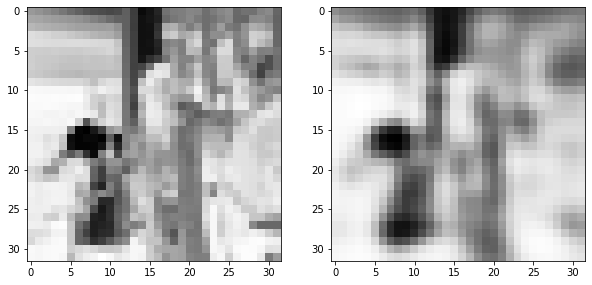

In [0]:
idx = 14
test_image = img_array[idx].reshape(1, 32, 32)
reconstr_image = ae(test_image)
# plt.imshow(reconstr_image[0], cmap='Greys')

fig=plt.figure(figsize=(10, 5))
columns = 2
rows = 1

figures = [test_image[0], reconstr_image[0]]

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(figures[i-1], cmap='Greys')
plt.show()

### Extract trained encoder for dimension reduction

In [0]:
encoder_layers = ["layer_size_128"]
def build_encoder(model, encoder_layers):
  output = [model.get_layer(name).output for name in encoder_layers]
  encoder = Model(model.input, output)
  return Model(model.input, output)

In [0]:
encoder = build_encoder(ae, encoder_layers)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (InputLayer)   [(None, 32, 32)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
layer_size_512 (Dense)       (None, 512)               524800    
_________________________________________________________________
layer_size_256 (Dense)       (None, 256)               131328    
_________________________________________________________________
layer_size_128 (Dense)       (None, 128)               32896     
Total params: 689,024
Trainable params: 689,024
Non-trainable params: 0
_________________________________________________________________


### Save out autoencoder and encoder

In [0]:
ae_filename = 'ae_model'
encoder_filename = 'encoder_model'

# saving autoencoder
ae.save(ae_filename)
# # saving encoder
encoder.save(encoder_filename)

INFO:tensorflow:Assets written to: ae_model/assets
INFO:tensorflow:Assets written to: encoder_model/assets


### Apply Dimensional Reduction

In [0]:
# load model
encoder = keras.models.load_model(encoder_filename)

In [0]:
# apply dimension reduction in batches
def dim_reduction(data, encoder, reduced_dim, saved_filename, batch_size=1000):
    """Encode input data with an encoder"""
    start_time = time.time()
    data_size = data.shape[0]
    result = np.memmap(saved_filename, dtype='float32', mode='w+',
                       shape=(data_size, reduced_dim))
    
    # batch dimensional reduction
    for i in range(data_size // batch_size + 1):
        start, end = i*batch_size, min((i+1)*batch_size, data_size)
        result[start:end] = encoder(data[start:end])
        time_elapsed = round(time.time()-start_time, 2)
        
        print(f'loading batch ({i+1} of {data_size // batch_size + 1})')
        print(f'time elapsed: {time_elapsed//60} minutes {round(time_elapsed%60, 2)} seconds')
        
    end_time = time.time()
    print(f'Total preprocessing time: {round((end_time-start_time)/60, 2)} minutes')
    return result

In [0]:
# test dim-reduction
raw_test_data = img_array[0:10]  # it will work with the entire test data
dim_reduced_file_name = 'dim_reduced_ae_img.pkl'
reduced_data = dim_reduction(data=raw_test_data, encoder=encoder, reduced_dim=128,
                             saved_filename=dim_reduced_file_name, batch_size=1000)

loading batch (1 of 1)
time elapsed: 0.0 minutes 0.01 seconds
Total preprocessing time: 0.0 minutes


In [0]:
print(reduced_data.shape)
reduced_data[0]

(10, 128)


memmap([ 1.7437235e+00,  3.3052881e+00,  1.7773213e+00,  3.7551072e-01,
         1.1858032e+00,  1.2779679e+01,  5.1152658e-01,  7.3696190e-01,
         7.0100765e+00, -4.7306505e-01,  3.8012378e+00,  1.1557517e+00,
         3.3754840e-01,  2.5043998e+00,  2.7788764e-01,  5.4398149e-01,
        -4.2382672e-01,  8.0856407e-01,  7.7784467e-01,  1.8934667e+00,
         1.2821466e+00,  3.1334296e-02,  1.0165935e+00,  7.8377330e-01,
         1.8019110e+00,  2.2981012e+00,  1.0731792e-02,  1.9839637e+00,
         7.6787853e-01,  3.9248247e+00,  1.8532287e-01,  2.0816579e+00,
         7.3543310e-01,  1.4539526e-01,  4.8649094e-01,  2.3626630e-01,
         9.1189277e-01,  3.6897357e+00,  1.1829450e+00,  9.2007005e-01,
         1.6247071e+00, -1.1516562e+00,  7.9530048e-01,  4.7277036e-01,
         4.2796925e-01,  1.7481964e+00, -7.9768915e-03, -1.0844327e-01,
         2.1630464e+00,  2.5309758e+00,  1.4737980e+00,  9.2265445e-01,
         4.2477870e+00,  4.3963652e+00,  3.3954522e-01, -1.19336

## Utility Functions

### Memory Usage Monitoring

In [0]:
import os
import psutil

In [0]:
# reference: https://psutil.readthedocs.io/en/latest/index.html?highlight=memory_info#psutil.Process.memory_info
pid = os.getpid()
ps = psutil.Process(pid)

# get memory use info
# before_memory = ps.memory_info()
# run_some_processes()
# after_memory = ps.memory_info()

# we only need to focus on ___ 
# memory_usage = after_memory - before_memory
# print(f'the total memory consumed is: {memory_usage} bytes')

# memory_usage.rss or print(memory_usage)
# print(memory_usage)
# >>> pmem(rss=953290752, vms=1925992448, shared=46641152, text=2330624, lib=0, data=1261969408, dirty=0)